In [ ]:
!git clone https://github.com/aashnakanuga/dl-math-word-problem-solving.git

Cloning into 'dl-math-word-problem-solving'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 30 (delta 3), reused 27 (delta 2), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [ ]:
import pandas as pd
import re
import os
import time
import random
import numpy as np

try:
  %tensorflow_version 2.x # enable TF 2.x in Colab
except Exception:
  pass

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from google.colab import drive
import pickle

import spacy

nlp = spacy.load("en_core_web_sm")
from nltk.translate.bleu_score import corpus_bleu

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # enable TF 2.x in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [ ]:
tf.__version__

'2.4.0'

In [ ]:
# Mount drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/'

Mounted at /gdrive


In [ ]:
!ls

dl-math-word-problem-solving  sample_data


In [ ]:
cd dl-math-word-problem-solving

/content/dl-math-word-problem-solving


### Creating the dataset of word problems

*Please add the correct path to load the data file*

In [ ]:
with open('data_final.pkl', 'rb') as f:
  df = pickle.load(f)

In [ ]:
df.shape

(38144, 2)

In [ ]:
df.head()

,Question,Equation
963,A painter needed to paint 12 rooms in a build...,X=(7.0*(12.0-5.0))
3897,Brenda had 253 raspberry. John gripped some ra...,X = 253 - 66
27626,Casey wants to share some Bread among 17 frien...,X = 39 * 17
32530,Liza had 34 Press. Thomas furnished him some m...,X = 64 - 34
16266,George wants to distribute 125 mangos among 25...,X = 125 / 25


In [ ]:
input_exps = list(df['Question'].values)

In [ ]:
def convert_eqn(eqn):
  '''
  Add a space between every character in the equation string.
  Eg: 'x = 23 + 88' becomes 'x =  2 3 + 8 8'
  '''
  elements = list(eqn)
  return ' '.join(elements)

In [ ]:
target_exps = list(df['Equation'].apply(lambda x: convert_eqn(x)).values)

In [ ]:
# Input: Word problem
input_exps[:5]

[' A painter needed to paint 12 rooms in a building. Each room takes 7 hours to paint. If he already painted 5 rooms, how much longer will he take to paint the rest? ',
 'Brenda had 253 raspberry. John gripped some raspberry. Now Brenda has 66  raspberry. How many did John grippeds?',
 'Casey wants to share some Bread among 17 friends.If each friend get 39 Bread, then how many Bread john would have?',
 'Liza had 34 Press. Thomas furnished him some more. Now Liza has 64 Press. How many did Thomas furnish him?',
 'George wants to distribute 125 mangos among 25 friends. How many would each friend acquire?']

In [ ]:
# Target: Equation
target_exps[:4]

['X = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'X   =   2 5 3   -   6 6',
 'X   =   3 9   *   1 7',
 'X   =   6 4   -   3 4']

In [ ]:
len(pd.Series(input_exps)), len(pd.Series(input_exps).unique())

(38144, 38144)

In [ ]:
len(pd.Series(target_exps)), len(pd.Series(target_exps).unique())

(38144, 23603)

### Preprocessing and Tokenizing the Input and Target exps

In [ ]:
def preprocess_input(sentence):
  '''
  For the word problem, convert everything to lowercase, add spaces around all
  punctuations and digits, and remove any extra spaces. 
  '''
  sentence = sentence.lower().strip()
  sentence = re.sub(r"([?.!,’])", r" \1 ", sentence)
  sentence = re.sub(r"([0-9])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)
  sentence = sentence.rstrip().strip()
  return sentence

In [ ]:
def preprocess_target(sentence):
  '''
  For the equation, convert it to lowercase and remove extra spaces
  '''
  sentence = sentence.lower().strip()
  return sentence

In [ ]:
preprocessed_input_exps = list(map(preprocess_input, input_exps))
preprocessed_target_exps = list(map(preprocess_target, target_exps))

In [ ]:
preprocessed_input_exps[:5]

['a painter needed to paint 1 2 rooms in a building . each room takes 7 hours to paint . if he already painted 5 rooms , how much longer will he take to paint the rest ?',
 'brenda had 2 5 3 raspberry . john gripped some raspberry . now brenda has 6 6 raspberry . how many did john grippeds ?',
 'casey wants to share some bread among 1 7 friends . if each friend get 3 9 bread , then how many bread john would have ?',
 'liza had 3 4 press . thomas furnished him some more . now liza has 6 4 press . how many did thomas furnish him ?',
 'george wants to distribute 1 2 5 mangos among 2 5 friends . how many would each friend acquire ?']

In [ ]:
preprocessed_target_exps[:5]

['x = ( 7 . 0 * ( 1 2 . 0 - 5 . 0 ) )',
 'x   =   2 5 3   -   6 6',
 'x   =   3 9   *   1 7',
 'x   =   6 4   -   3 4',
 'x   =   1 2 5   /   2 5']

In [ ]:
def tokenize(lang):
  '''
  Tokenize the given list of strings and return the tokenized output
  along with the fitted tokenizer.
  '''
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  return tensor, lang_tokenizer

In [ ]:
input_tensor, inp_lang_tokenizer = tokenize(preprocessed_input_exps)

In [ ]:
len(inp_lang_tokenizer.word_index), len(input_tensor)


(5887, 38144)

In [ ]:
len(input_tensor)

38144

In [ ]:
target_tensor, targ_lang_tokenizer = tokenize(preprocessed_target_exps)

In [ ]:
old_len = len(targ_lang_tokenizer.word_index)
print(old_len)
len(target_tensor)

45


38144

In [ ]:
def append_start_end(x,last_int):
  '''
  Add integers for start and end tokens for input/target exps
  '''
  l = []
  l.append(last_int+1)
  l.extend(x)
  l.append(last_int+2)
  return l

In [ ]:
input_tensor_list = [append_start_end(i,len(inp_lang_tokenizer.word_index)) for i in input_tensor]
target_tensor_list = [append_start_end(i,len(targ_lang_tokenizer.word_index)) for i in target_tensor]

In [ ]:
input_tensor_list

[[5888,
  104,
  2454,
  903,
  32,
  1153,
  5,
  7,
  1625,
  44,
  104,
  1626,
  1,
  10,
  1989,
  754,
  17,
  587,
  32,
  1153,
  1,
  18,
  27,
  822,
  2253,
  16,
  1625,
  25,
  2,
  144,
  1273,
  272,
  27,
  96,
  32,
  1153,
  49,
  592,
  3,
  5889],
 [5888,
  280,
  6,
  7,
  16,
  9,
  83,
  1,
  45,
  173,
  8,
  83,
  1,
  13,
  280,
  12,
  15,
  15,
  83,
  1,
  2,
  4,
  20,
  45,
  174,
  3,
  5889],
 [5888,
  811,
  43,
  32,
  52,
  8,
  67,
  31,
  5,
  17,
  23,
  1,
  18,
  10,
  30,
  33,
  9,
  22,
  67,
  25,
  39,
  2,
  4,
  67,
  45,
  36,
  19,
  3,
  5889],
 [5888,
  2102,
  6,
  9,
  14,
  93,
  1,
  119,
  326,
  11,
  8,
  28,
  1,
  13,
  2102,
  12,
  15,
  14,
  93,
  1,
  2,
  4,
  20,
  119,
  327,
  11,
  3,
  5889],
 [5888,
  160,
  43,
  32,
  207,
  5,
  7,
  16,
  146,
  31,
  7,
  16,
  23,
  1,
  2,
  4,
  36,
  10,
  30,
  114,
  3,
  5889],
 [5888,
  116,
  12,
  5,
  14,
  21,
  38,
  1,
  229,
  37,
  11,
  14,
  7,
  28,
  1,
  

In [ ]:
# Pad all sequences such that they are of equal length
input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor_list, padding='post')
target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor_list, padding='post')

In [ ]:
input_tensor

array([[5888,  104, 2454, ...,    0,    0,    0],
       [5888,  280,    6, ...,    0,    0,    0],
       [5888,  811,   43, ...,    0,    0,    0],
       ...,
       [5888,  380,   12, ...,    0,    0,    0],
       [5888,  167,    6, ...,    0,    0,    0],
       [5888,  404,    6, ...,    0,    0,    0]], dtype=int32)

In [ ]:
target_tensor
print(target_tensor.shape)

(38144, 66)


In [ ]:
# Here we are increasing the vocabulary size of the target, by adding a
# few extra vocabulary words (which will not actually be used) as otherwise the
# small vocab size causes issues downstream in the network.
keys = [str(i) for i in range(10,51)]
for i,k in enumerate(keys):
  #print(i, k)
  targ_lang_tokenizer.word_index[k]=len(targ_lang_tokenizer.word_index)+i+4

In [ ]:
len(targ_lang_tokenizer.word_index)

86

### Create a tf.data dataset

In [ ]:
# Creating training and validation sets
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor,
                                                                                                target_tensor,
                                                                                                test_size=0.05,
                                                                                                random_state=42)

In [ ]:
len(input_tensor_train)

36236

In [ ]:
len(input_tensor_val)

1908

In [ ]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = len(inp_lang_tokenizer.word_index)+3
target_vocab_size = len(targ_lang_tokenizer.word_index)+3
dropout_rate = 0.0

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 124]), TensorShape([64, 66]))

### Transformer Model

#### Positional Encoding

In [ ]:
# We provide positional information about the data to the model,
# otherwise each sentence will be treated as Bag of Words
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

#### Masking

In [ ]:
# mask all elements are that not words (padding) so that it is not treated as input
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask

In [ ]:
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


#### Attention

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

#### Pointwise Feed forward network

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

#### Encoder Layer

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # normalize data per feature instead of batch
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):
    # Multi-head attention layer
    attn_output, _ = self.mha(x, x, x, mask) 
    attn_output = self.dropout1(attn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out1 = self.layernorm1(x + attn_output)
    
    # Feedforward layer
    ffn_output = self.ffn(out1)
    ffn_output = self.dropout2(ffn_output, training=training)
    # add residual connection to avoid vanishing gradient problem
    out2 = self.layernorm2(out1 + ffn_output)
    return out2

#### Encoder

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)
    
    # Create encoder layers (count: num_layers)
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x 

#### Decoder Layer

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    # Masked multihead attention layer (padding + look-ahead)
    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
    attn1 = self.dropout1(attn1, training=training)
    # again add residual connection
    out1 = self.layernorm1(attn1 + x)
    
    # Masked multihead attention layer (only padding)
    # with input from encoder as Key and Value, and input from previous layer as Query
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)
    attn2 = self.dropout2(attn2, training=training)
    # again add residual connection
    out2 = self.layernorm2(attn2 + out1)
    
    # Feedforward layer
    ffn_output = self.ffn(out2)
    ffn_output = self.dropout3(ffn_output, training=training)
    # again add residual connection
    out3 = self.layernorm3(ffn_output + out2)
    return out3, attn_weights_block1, attn_weights_block2

#### Decoder

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
     
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)
    
    # Create decoder layers (count: num_layers)
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    
    x += self.pos_encoding[:,:seq_len,:]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      # store attenion weights, they can be used to visualize while translating
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    return x, attention_weights

#### Transformer

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    # Pass the input to the encoder
    enc_output = self.encoder(inp, training, enc_padding_mask)
    
    # Pass the encoder output to the decoder
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    # Pass the decoder output to the last linear layer
    final_output = self.final_layer(dec_output)
    
    return final_output, attention_weights

#### Optimizer and Loss

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [ ]:
learning_rate = CustomSchedule(d_model)

# Adam optimizer with a custom learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  # Apply a mask to paddings (0)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [ ]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, 
                          pe_input=input_vocab_size, 
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Decoder padding mask
  dec_padding_mask = create_padding_mask(inp)
  
  # Look ahead mask (for hiding the rest of the sequence in the 1st decoder attention layer)
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

### Checkpoints

In [ ]:
# !rm -r /gdrive/My\ Drive/ADL\ Project/checkpoints/training_checkpoints/akshata_transfomer

In [ ]:
checkpoint_dir = os.path.join(drive_root, "ADL Project/checkpoints")
checkpoint_dir = os.path.join(checkpoint_dir, "training_checkpoints/akshata_transfomer")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
  print("Checkpoints folder already exists")
else:
  print("Creating a checkpoints directory")
  os.makedirs(checkpoint_dir)


checkpoint = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

Checkpoints directory is /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/akshata_transfomer
Checkpoints folder already exists


In [ ]:
latest = ckpt_manager.latest_checkpoint
latest

'/gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/akshata_transfomer/ckpt-5'

In [ ]:
if latest:
  epoch_num = int(latest.split('/')[-1].split('-')[-1])
  checkpoint.restore(latest)
  print ('Latest checkpoint restored!!')
else:
  epoch_num = 0

Latest checkpoint restored!!


In [ ]:
epoch_num

5

#### Training

In [ ]:
EPOCHS = 50

def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [ ]:
for epoch in range(epoch_num, EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> question, tar -> equation
  for (batch, (inp, tar)) in enumerate(dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  ckpt_save_path = ckpt_manager.save()
  print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 6 Batch 0 Loss 0.0151 Accuracy 0.1257
Epoch 6 Batch 50 Loss 0.0150 Accuracy 0.1296
Epoch 6 Batch 100 Loss 0.0125 Accuracy 0.1288
Epoch 6 Batch 150 Loss 0.0137 Accuracy 0.1288
Epoch 6 Batch 200 Loss 0.0136 Accuracy 0.1285
Epoch 6 Batch 250 Loss 0.0141 Accuracy 0.1285
Epoch 6 Batch 300 Loss 0.0145 Accuracy 0.1286
Epoch 6 Batch 350 Loss 0.0143 Accuracy 0.1287
Epoch 6 Batch 400 Loss 0.0141 Accuracy 0.1287
Epoch 6 Batch 450 Loss 0.0141 Accuracy 0.1287
Epoch 6 Batch 500 Loss 0.0145 Accuracy 0.1287
Epoch 6 Batch 550 Loss 0.0144 Accuracy 0.1287
Saving checkpoint for epoch 6 at /gdrive/My Drive/ADL Project/checkpoints/training_checkpoints/akshata_transfomer/ckpt-6
Epoch 6 Loss 0.0142 Accuracy 0.1286
Time taken for 1 epoch: 159.9977765083313 secs

Epoch 7 Batch 0 Loss 0.0073 Accuracy 0.1272
Epoch 7 Batch 50 Loss 0.0143 Accuracy 0.1282
Epoch 7 Batch 100 Loss 0.0135 Accuracy 0.1287
Epoch 7 Batch 150 Loss 0.0143 Accuracy 0.1287
Epoch 7 Batch 200 Loss 0.0145 Accuracy 0.1286
Epoch 7 Batch 250 L

### Evaluate

In [ ]:
def evaluate(inp_sentence):
  start_token = [len(inp_lang_tokenizer.word_index)+1]
  end_token = [len(inp_lang_tokenizer.word_index)+2]
  
  # inp sentence is the word problem, hence adding the start and end token
  inp_sentence = start_token + [inp_lang_tokenizer.word_index[i] for i in preprocess_input(inp_sentence).split(' ')]+end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  # start with equation's start token
  decoder_input = [old_len+1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :] 
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == old_len+2:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)
  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))
  
  sentence = preprocess_input(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')
    
    fontdict = {'fontsize': 10}
    
    ax.set_xticks(range(len(sentence.split(' '))+2))
    ax.set_yticks(range(len([targ_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2]])+3))
    
    
    ax.set_ylim(len([targ_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2]]), -0.5)
        
    ax.set_xticklabels(
        ['<start>']+sentence.split(' ')+['<end>'], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([targ_lang_tokenizer.index_word[i] for i in list(result.numpy()) 
                        if i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2]], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [ ]:
MAX_LENGTH = 40

In [ ]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)
  # print('result',list(result.numpy()))

  # use the result tokens to convert prediction into a list of characters
  # (not inclusing padding, start and end tokens)
  predicted_sentence = [targ_lang_tokenizer.index_word[i] for i in list(result.numpy()) if (i < len(targ_lang_tokenizer.word_index) and i not in [0,46,47])]  

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(' '.join(predicted_sentence)))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

### Get Accuracy and Corpus BLEU

In [ ]:
def evaluate_results(inp_sentence):
  start_token = [len(inp_lang_tokenizer.word_index)+1]
  end_token = [len(inp_lang_tokenizer.word_index)+2]
  
  # inp sentence is the word problem, hence adding the start and end token
  inp_sentence = start_token + list(inp_sentence.numpy()[0]) + end_token
  
  encoder_input = tf.expand_dims(inp_sentence, 0)
  
  
  decoder_input = [old_len+1]
  output = tf.expand_dims(decoder_input, 0)
    
  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if predicted_id == old_len+2:
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
dataset_val = dataset_val.batch(1, drop_remainder=True)

In [ ]:
y_true = []
y_pred = []
acc_cnt = 0

a = 0
for (inp_val_batch, target_val_batch) in iter(dataset_val):
  a += 1
  if a % 10 == 0:
    print(a)
    print("Accuracy count: ",acc_cnt)
    print('------------------')
  target_sentence = ''
  for i in target_val_batch.numpy()[0]:
    if i not in [0,old_len+1,old_len+2]:
      target_sentence += (targ_lang_tokenizer.index_word[i] + ' ')
  
  y_true.append([target_sentence.split(' ')[:-1]])
  
  result, _ = evaluate_results(inp_val_batch)
  predicted_sentence = [targ_lang_tokenizer.index_word[i] for i in list(result.numpy()) if (i < len(targ_lang_tokenizer.word_index) and i not in [0,old_len+1,old_len+2])] 
  y_pred.append(predicted_sentence)
  
  if target_sentence.split(' ')[:-1] == predicted_sentence:
    acc_cnt += 1

10
Accuracy count:  6
------------------
20
Accuracy count:  9
------------------
30
Accuracy count:  15
------------------
40
Accuracy count:  22
------------------
50
Accuracy count:  27
------------------
60
Accuracy count:  33
------------------
70
Accuracy count:  37
------------------
80
Accuracy count:  44
------------------
90
Accuracy count:  51
------------------
100
Accuracy count:  57
------------------
110
Accuracy count:  65
------------------
120
Accuracy count:  71
------------------
130
Accuracy count:  77
------------------
140
Accuracy count:  84
------------------
150
Accuracy count:  91
------------------
160
Accuracy count:  96
------------------
170
Accuracy count:  103
------------------
180
Accuracy count:  111
------------------
190
Accuracy count:  117
------------------
200
Accuracy count:  123
------------------
210
Accuracy count:  128
------------------
220
Accuracy count:  136
------------------
230
Accuracy count:  142
------------------
240
Accuracy co

In [ ]:
len(y_true), len(y_pred)

(1908, 1908)

In [ ]:
print('Corpus BLEU score of the model: ', corpus_bleu(y_true, y_pred))

Corpus BLEU score of the model:  0.7662671260476241


In [ ]:
print('Accuracy of the model: ', acc_cnt/len(input_tensor_val))

Accuracy of the model:  0.5639412997903563


#### Translation

In [ ]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[242] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])

In [ ]:
check_str

'victor had some car . john took 3 0 from him . now victor has 6 8 car . how many car victor had originally ?'

Input: victor had some car . john took 3 0 from him . now victor has 6 8 car . how many car victor had originally ?
Predicted translation: x = 6 8 + 3 0


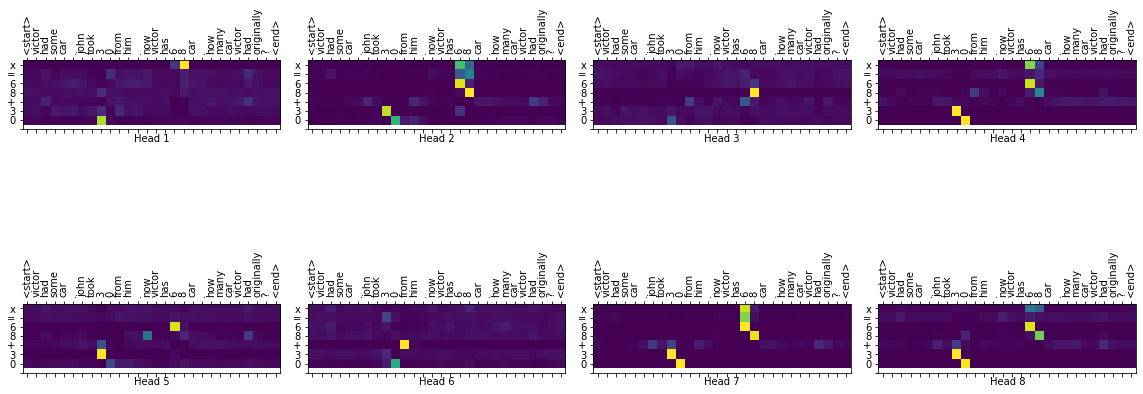

In [ ]:
translate(check_str,
          plot='decoder_layer4_block2')

In [ ]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[0] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])
check_str

'ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ?'

Input: ronnie had some blackberry . he divide each blackberry into 1 3 slices . if total 1 8 9 blackberry slices ronnie make , then how many blackberry ronnie had ?
Predicted translation: x = 1 8 9 / 1 3


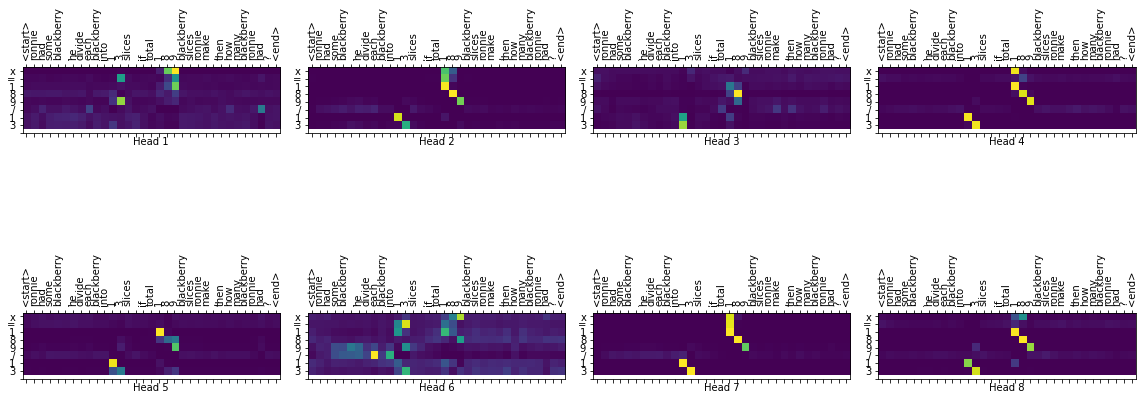

In [ ]:
translate(check_str,
          plot='decoder_layer4_block2')

In [ ]:
check_str = ' '.join([inp_lang_tokenizer.index_word[i] for i in input_tensor_val[234] if i not in [0,
                                                                                                  len(inp_lang_tokenizer.word_index)+1,
                                                                                                  len(inp_lang_tokenizer.word_index)+2]])
check_str

'april had 8 biscuit . he cube each biscuit into 1 9 slices . how many biscuit slices did april make ?'

Input: april had 8 biscuit . he cube each biscuit into 1 9 slices . how many biscuit slices did april make ?
Predicted translation: x = 1 9 * 8


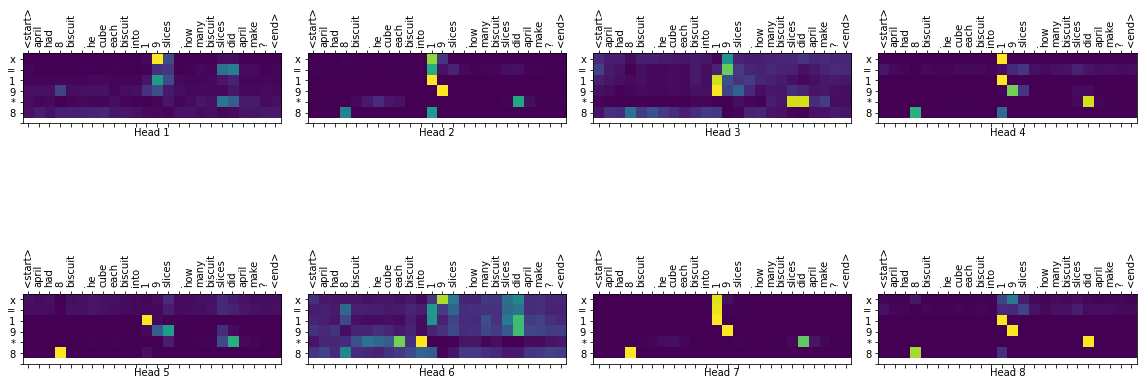

In [ ]:
translate(check_str,
          plot='decoder_layer4_block2')

Input: Jerry had 135 pens. John took 19 from him. How many pens Jerry have left?
Predicted translation: x = 1 3 5 - 1 9


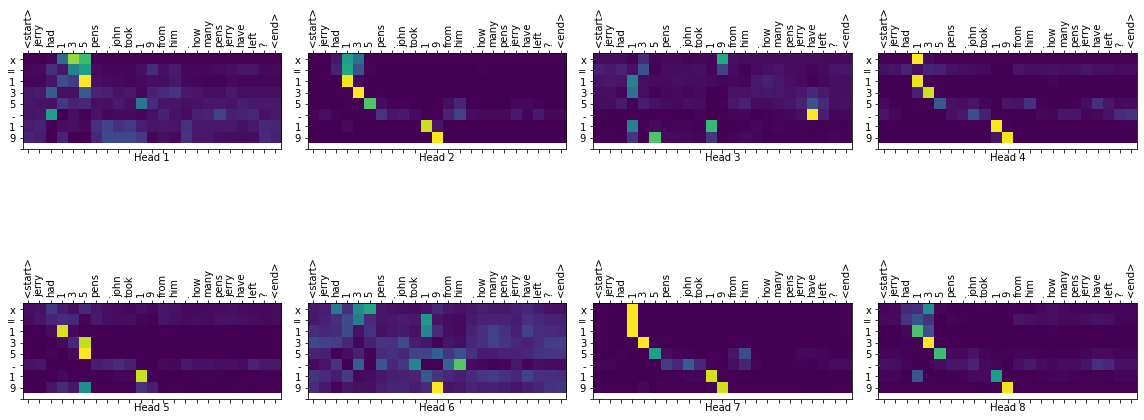

In [ ]:
translate("Jerry had 135 pens. John took 19 from him. How many pens Jerry have left?",
          plot='decoder_layer4_block2')

### Conclusions

We see that the scores for the transformer model are much higher than the Bidirectional Seq2Seq model, and that the attention plots are also better (all the layers and heads) than the previous model. This indicates that this model performs better on our data than the Seq2Seq model. BUt we can see that it has still not been able to learn which words to give proper attention to while deciding the operator to use. 
Moreover, the issue of the dataset not being diverse enough still remains, and this model does not perform very well on questions that do not match the rough format of the questions in the data. 

Sources:
1. https://web.stanford.edu/class/cs224n/reports/custom/15843468.pdf
2. https://www.tensorflow.org/tutorials/text/transformer#top_of_page